In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU, LSTM, Dense, BatchNormalization, Dropout, InputLayer
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(42)

In [4]:
# Import locational_marginal_price Dataset
df = pd.read_csv('./Cleaned_Data/LMP_and_feature_data.csv', index_col=0)
df.index = pd.to_datetime(df.index,  utc=True)
df.index = df.index.tz_convert("America/Los_Angeles")

In [5]:
df.columns = ['_'.join(colname.split()) for colname in df.columns]
df.columns = [colname.replace('-','_') for colname in df.columns]

In [6]:
# Rename Energy Component Columns for understandability
df.columns = [x.replace('LMP', 'locational_marginal_price') for x in df.columns]
df.columns = [x.replace('MCC', 'marginal_congestion_component') for x in df.columns]
df.columns = [x.replace('MCE', 'marginal_energy_component') for x in df.columns]
df.columns = [x.replace('MCL', 'marginal_loss_component') for x in df.columns]
df.columns = [x.replace('MGHG', 'marginal_greenhouse_gas_component') for x in df.columns]

"RT" prefix refers to prices in real-time market while "DA" prefix refers to prices in the day-ahead market

In [7]:
df.head(3)

,RT_locational_marginal_price,RT_marginal_congestion_component,RT_marginal_energy_component,RT_marginal_loss_component,RT_marginal_greenhouse_gas_component,DA_locational_marginal_price,DA_marginal_congestion_component,DA_marginal_energy_component,DA_marginal_loss_component,DA_marginal_greenhouse_gas_component,...,RT_locational_marginal_price_in_12_hrs,RT_locational_marginal_price_in_2_hrs,target_hour,target_friday,target_weekend,target_month,target_sin_month,target_cos_month,target_sin_hour,target_cos_hour
2020-04-20 01:00:00-07:00,15.467644,0.0,15.515472,-0.047827,0.0,20.64034,0.0,20.47856,0.16178,NaN,...,20.768937,18.769981,3.0,0.0,0.0,4.0,0.866025,-0.5,0.707107,0.707107
2020-04-20 02:00:00-07:00,17.830759,0.0,18.047457,-0.216696,0.0,20.44476,0.0,20.33292,0.11183,NaN,...,15.283187,19.736117,4.0,0.0,0.0,4.0,0.866025,-0.5,0.866025,0.500000
2020-04-20 03:00:00-07:00,18.769981,0.0,19.070217,-0.300238,0.0,20.53888,0.0,20.44890,0.08998,NaN,...,64.724663,16.848482,5.0,0.0,0.0,4.0,0.866025,-0.5,0.965926,0.258819


# Finalizing Dataset for Initial Models

In [8]:
# Create list of endogenous variables

endog = [# Renewable Forecasts for different areas
         'NP15_Solar_Renewable_Forecast_Day_Ahead', 'NP15_Wind_Renewable_Forecast_Day_Ahead',
         'SP15_Solar_Renewable_Forecast_Day_Ahead', 'SP15_Wind_Renewable_Forecast_Day_Ahead',
         'ZP26_Solar_Renewable_Forecast_Day_Ahead',
         # Real Time Prices
         'RT_locational_marginal_price', 'RT_marginal_congestion_component', 'RT_marginal_energy_component', 'RT_marginal_loss_component', 'RT_marginal_greenhouse_gas_component', 
         'lagged_2hr_RT_locational_marginal_price', 'lagged_4hr_RT_locational_marginal_price', 'lagged_12hr_RT_locational_marginal_price', 'lagged_22hr_RT_locational_marginal_price',
         # Day-Ahead Prices
         'DA_locational_marginal_price', 'DA_marginal_congestion_component', 'DA_marginal_energy_component', 'DA_marginal_loss_component',
         'lagged_2hr_DA_locational_marginal_price', 'lagged_4hr_DA_locational_marginal_price', 'lagged_12hr_DA_locational_marginal_price', 'lagged_22hr_DA_locational_marginal_price',
         # Lagged Generation Variables
         'renew_forecast_error', 'Export', 'Generation',  'Import',
         'lagged_2hr_renew_forecast_error', 'lagged_2hr_Export','lagged_2hr_Generation', 'lagged_2hr_Import',
         'lagged_4hr_renew_forecast_error', 'lagged_4hr_Export','lagged_4hr_Generation', 'lagged_4hr_Import',
         'lagged_12hr_renew_forecast_error', 'lagged_12hr_Export','lagged_12hr_Generation', 'lagged_12hr_Import',
         # Temperature variables
         'temperature_2m', 'lagged_2hr_temp', 'lagged_4hr_temp', 'lagged_12hr_temp', 'lagged_22hr_temp', 'lagged_23hr_temp',
         # Time-Related Variables
         'target_friday', 'target_weekend', 
         'target_sin_hour', 'target_cos_hour',
         'target_sin_month', 'target_cos_month']

In [9]:
# Check how manny null values there are by feature
df.isna().sum()[df.isna().sum()>0]

DA_marginal_greenhouse_gas_component               6047
NP15_Solar_Renewable_Forecast_Actual_Generation       5
NP15_Wind_Renewable_Forecast_Actual_Generation        6
SP15_Solar_Renewable_Forecast_Actual_Generation       5
SP15_Wind_Renewable_Forecast_Actual_Generation        5
ZP26_Solar_Renewable_Forecast_Actual_Generation       5
Total_Solar_Actual                                    5
Total_Wind_Actual                                     6
Total_Wind_Solar_Actual                               6
renew_forecast_error                                  6
solar_forecast_error                                  5
wind_forecast_error                                   6
lagged_2hr_RT_locational_marginal_price             165
lagged_4hr_RT_locational_marginal_price             325
lagged_12hr_RT_locational_marginal_price            965
lagged_20hr_RT_locational_marginal_price           1605
lagged_22hr_RT_locational_marginal_price           1765
lagged_23hr_RT_locational_marginal_price        

In [10]:
# Drop hours with missing data in feature set
df.dropna(axis=0, subset=endog, inplace=True)

In [11]:
df.shape

(24778, 99)

# Train - Test Split and Diagnostic Functions

In [12]:
# For the models in this analysis, we will train using data from Apr 2020 to July 2022 and test against data from August 2022 onwards
# The target variable is the RTLMP two hours after the features are observed
train = df[df.index < '2022-07-29'].dropna(subset=endog + ['RT_locational_marginal_price_in_2_hrs'])
X_train = train[endog]
y_train = train['RT_locational_marginal_price_in_2_hrs']

test = df[df.index >= '2022-07-29'].dropna(subset=endog + ['RT_locational_marginal_price_in_2_hrs'])
X_test = test[endog]
y_test = test['RT_locational_marginal_price_in_2_hrs']

In [13]:
def plot_lmp_pred(y_true, y_pred, alpha=1):
    """
    Plots the results of a time-series prediction
    
    Parameters
    ----------
    y_true: Series of shape (n_samples, )
        The true values being predicted. Must be a pandas Series with dates as the index
    y_pred: array-like of shape (n_samples,)
        The prediction from the forecasting model.
    
    Returns
    ----------
    fig: matplotlib plot
    """
    fig=plt.figure()
    plt.plot(y_true, label='Actual')
    plt.plot(pd.Series(y_pred, index=y_true.index), label='Predicted', alpha=alpha)
    plt.xticks(rotation=45)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Real Time locational_marginal_price')
    
    return fig
    

In [14]:
# Initialize a dataframe to store error metrics for each model

err_metrics = ['r2', 'rmse', 'mae', 'mape']

error_df = pd.DataFrame(columns=err_metrics)
error_df.index.name = 'Model'

# Persistence Model

In [15]:
# Model predicts that RTLMP in 2 hours is the same as RTLMP 22 hours ago (i.e., 24 hours before the target)
persist_y_pred_past_day = np.array(X_test['lagged_22hr_RT_locational_marginal_price'])

# Model predicts that RTLMP in 2 hours is the same as current RTLMP
persist_y_pred_curr_hour = np.array(X_test['RT_locational_marginal_price'])

Results for 24-hour lagged persistence model
--------------------------------------------
R2 Score: 0.41
RMSE 68.19
MAE 27.75
MAPE 24.78


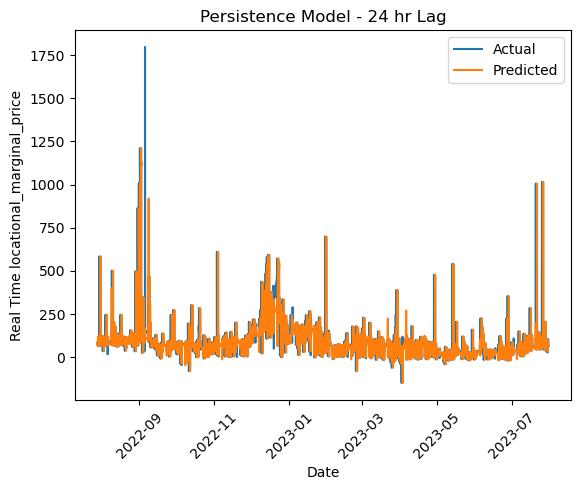

In [88]:
plot_lmp_pred(y_test, persist_y_pred_past_day)

error_df.loc['persist_prev_day', 'r2'] = metrics.r2_score(y_test, persist_y_pred_past_day)
error_df.loc['persist_prev_day', 'rmse'] = metrics.mean_squared_error(y_test, persist_y_pred_past_day, squared=False)
error_df.loc['persist_prev_day', 'mae'] = metrics.mean_absolute_error(y_test, persist_y_pred_past_day)
error_df.loc['persist_prev_day', 'mape'] = metrics.mean_absolute_percentage_error(y_test, persist_y_pred_past_day)

print('Results for 24-hour lagged persistence model', '--------------------------------------------', sep='\n')
print("R2 Score:", round(error_df.loc['persist_prev_day', 'r2'], 2))
print("RMSE", round(error_df.loc['persist_prev_day', 'rmse'], 2))
print("MAE", round(error_df.loc['persist_prev_day', 'mae'], 2))
print("MAPE", round(error_df.loc['persist_prev_day', 'mape'], 2))

plt.title('Persistence Model - 24 hr Lag')
plt.show()

Overlap between Actual and Predicted locational_marginal_price makes it difficult to discern 'Actual' from 'Predicted' on such a long timeline

Results for 2-hour lagged persistence model
-------------------------------------------
R2 Score: 0.47
RMSE 64.47
MAE 23.84
MAPE 6.6


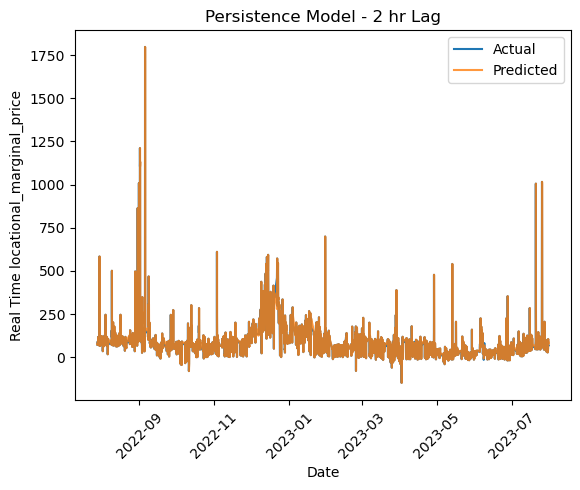

In [17]:
plot_lmp_pred(y_test, persist_y_pred_curr_hour, alpha=0.8)

error_df.loc['persist_curr_hour', 'r2'] = metrics.r2_score(y_test, persist_y_pred_curr_hour)
error_df.loc['persist_curr_hour', 'rmse'] = metrics.mean_squared_error(y_test, persist_y_pred_curr_hour, squared=False)
error_df.loc['persist_curr_hour', 'mae'] = metrics.mean_absolute_error(y_test, persist_y_pred_curr_hour)
error_df.loc['persist_curr_hour', 'mape'] = metrics.mean_absolute_percentage_error(y_test, persist_y_pred_curr_hour)

print('Results for 2-hour lagged persistence model', '-------------------------------------------', sep='\n')
print("R2 Score:", round(error_df.loc['persist_curr_hour', 'r2'], 2))
print("RMSE", round(error_df.loc['persist_curr_hour', 'rmse'], 2))
print("MAE", round(error_df.loc['persist_curr_hour', 'mae'], 2))
print("MAPE", round(error_df.loc['persist_curr_hour', 'mape'], 2))
plt.title('Persistence Model - 2 hr Lag')
plt.show()

Zooming in on small portions of the data reveals instances in which the 2-hour persistence model exhibits large prediction errors (see lagged spike on 7/30)

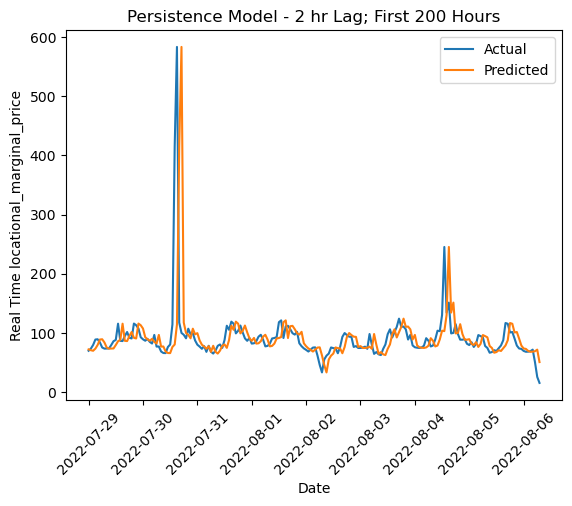

In [18]:
# View first 200 hours
plot_lmp_pred(y_test[:200], persist_y_pred_curr_hour[:200])
plt.title('Persistence Model - 2 hr Lag; First 200 Hours')
plt.show()

# Random Forest

In [19]:
def rf_reg_grid_search(X_train, y_train, param_distributions, seed):
    """
    Performs a grid search for a random forest classifier using cross-validation.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        The training input samples.
    y_train : array-like of shape (n_samples,)
        The target values.
    param_grid : dict
        Dictionary with parameters names (str) as keys and lists of parameter
        settings to try as values.

    Returns
    -------
    best_params : dict
        Dictionary with the best parameters found during the grid search.
    """

    # Define the random forest classifier
    rf = RandomForestRegressor()
    
    # Set a seed for reproducible results
    np.random.seed(seed)
    
    # Perform a grid search using cross-validation
    grid_search = RandomizedSearchCV(rf, 
                                     param_distributions=param_distributions, 
                                     cv=5, 
                                     n_iter=5,
                                     scoring='neg_root_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters
    print("Best hyperparameters found during grid search:")
    best_params = grid_search.best_params_
    print(best_params)

    return best_params

In [20]:
# Define parameters to test in grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 8]
}

In [21]:
# Perform grid search
rf_reg_best_params = rf_reg_grid_search(X_train=X_train, y_train=y_train, param_distributions=param_grid, seed=42)

Best hyperparameters found during grid search:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_depth': 10}


In [22]:
# Run Random Forest using parameters from best model
rf_reg = RandomForestRegressor(**rf_reg_best_params).fit(X_train, y_train)

Results for Random Forest model
-------------------------------
R2 Score: 0.69
RMSE 49.36
MAE 20.49
MAPE 25.09


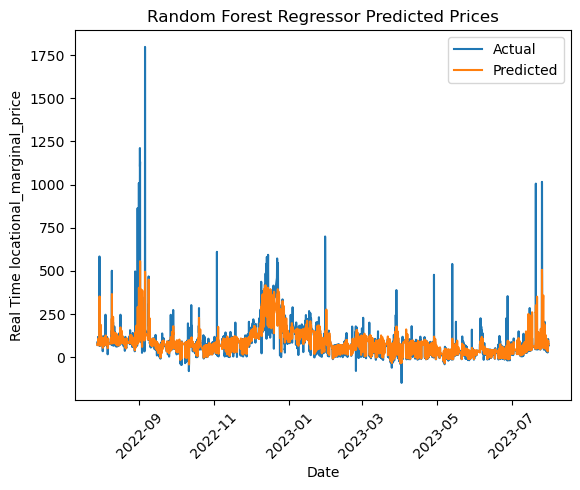

In [23]:
rf_reg_pred = rf_reg.predict(X_test)

print('Results for Random Forest model', '-------------------------------', sep='\n')
error_df.loc['Random Forest', 'r2'] = metrics.r2_score(y_test, rf_reg_pred)
error_df.loc['Random Forest', 'rmse'] = metrics.mean_squared_error(y_test, rf_reg_pred, squared=False)
error_df.loc['Random Forest', 'mae'] = metrics.mean_absolute_error(y_test, rf_reg_pred)
error_df.loc['Random Forest', 'mape'] = metrics.mean_absolute_percentage_error(y_test, rf_reg_pred)


print("R2 Score:", round(error_df.loc['Random Forest', 'r2'], 2))
print("RMSE", round(error_df.loc['Random Forest', 'rmse'], 2))
print("MAE", round(error_df.loc['Random Forest', 'mae'], 2))
print("MAPE", round(error_df.loc['Random Forest', 'mape'], 2))

plot_lmp_pred(y_test, rf_reg_pred)
plt.title('Random Forest Regressor Predicted Prices')
plt.show()

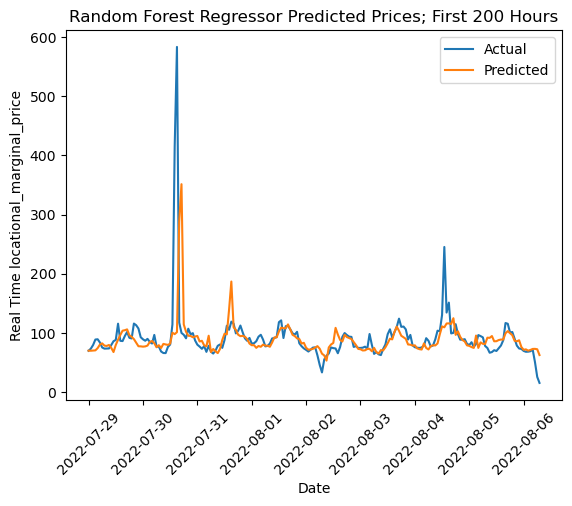

In [24]:
rf_reg_pred_subset = rf_reg.predict(X_test[:200])

plot_lmp_pred(y_test[:200], rf_reg_pred_subset)
plt.title('Random Forest Regressor Predicted Prices; First 200 Hours')
plt.show()

Top 10 most important features used by the Random Forest model include lagged energy prices, temperature and generation

In [25]:
# Top 10 features with most importance
pd.DataFrame(zip(endog, rf_reg.feature_importances_), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).round(2).iloc[:10,]

,Feature,Importance
5,RT_locational_marginal_price,0.31
21,lagged_22hr_DA_locational_marginal_price,0.14
13,lagged_22hr_RT_locational_marginal_price,0.13
17,DA_marginal_loss_component,0.06
24,Generation,0.05
38,temperature_2m,0.03
6,RT_marginal_congestion_component,0.03
36,lagged_12hr_Generation,0.03
31,lagged_4hr_Export,0.02
10,lagged_2hr_RT_locational_marginal_price,0.02


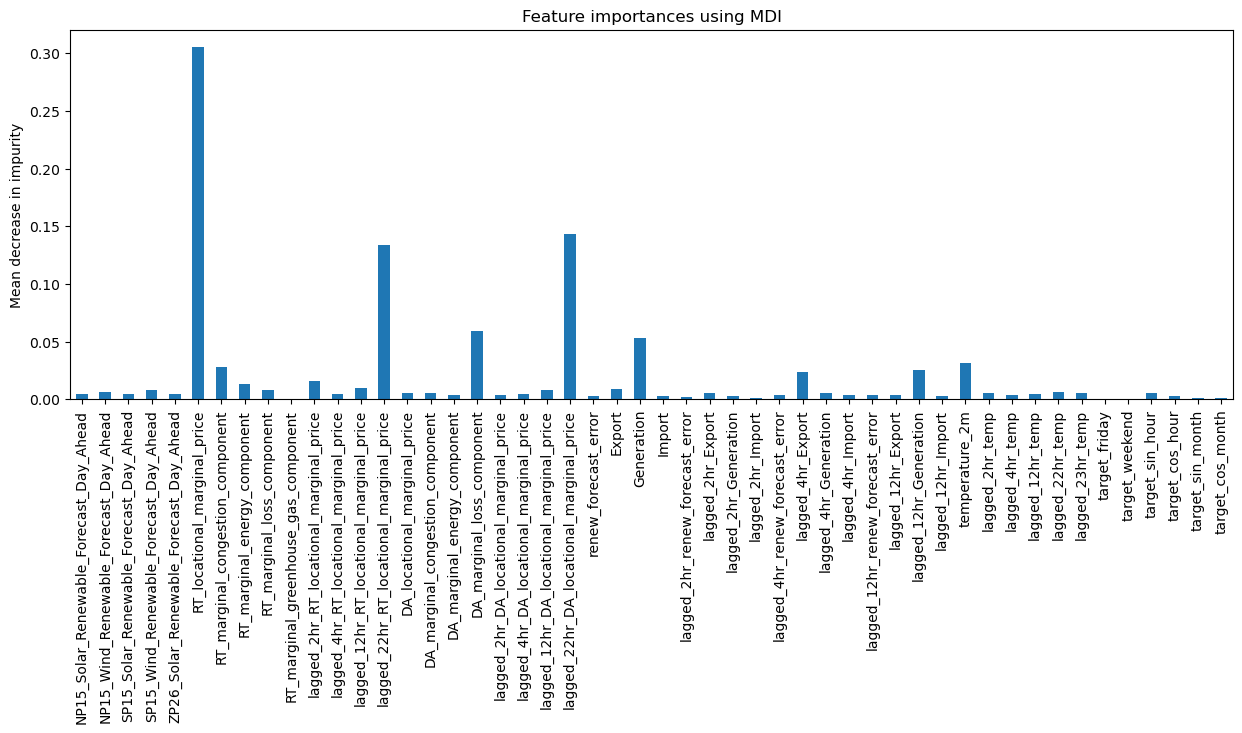

In [26]:
importances = rf_reg.feature_importances_

forest_importances = pd.Series(importances, index=endog)
fig, ax = plt.subplots()
fig.set_figwidth(15)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

# XGBoost

In [27]:
# Converting data to np arrays for feeding into XGB model
train_arr = np.array(train)
X_train_arr = np.array(X_train)
y_train_arr = np.array(y_train)

test_arr = np.array(test)
X_test_arr = np.array(X_test)
y_test_arr = np.array(y_test)

In [28]:
def xgb_reg_grid_search(X_train, y_train, param_distributions, seed):
    """
    Performs a grid search for an xgboost classifier using cross-validation.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        The training input samples.
    y_train : array-like of shape (n_samples,)
        The target values.
    param_grid : dict
        Dictionary with parameters names (str) as keys and lists of parameter
        settings to try as values.

    Returns
    -------
    best_params : dict
        Dictionary with the best parameters found during the grid search.
    """

    # Define the random forest classifier
    clf = XGBRegressor(verbosity=0)

    # Set a seed for reproducible results
    np.random.seed(seed)

    # Perform a grid search using cross-validation
    grid_search = RandomizedSearchCV(clf, 
                                     param_distributions=param_distributions, 
                                     cv=5, 
                                     n_iter=5,
                                     scoring='neg_root_mean_squared_error',
                                     verbose=0)
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters
    print("Best hyperparameters found during grid search:")
    best_params = grid_search.best_params_
    print(best_params)

    return best_params

In [29]:
# Define parameters to test in grid search
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [30]:
# Perform grid search
xgb_vals_best_params = xgb_reg_grid_search(X_train=X_train_arr, y_train=y_train_arr, param_distributions=param_grid, seed=42)

Best hyperparameters found during grid search:
{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}


In [31]:
# Run XGBoost using parameters from best model
xgb_reg = XGBRegressor(**xgb_vals_best_params).fit(X_train, y_train)

In [32]:
xgb_reg_pred = xgb_reg.predict(X_test_arr)

Results for XGBoost model
-------------------------
R2 Score: 0.58
RMSE 57.75
MAE 25.17
MAPE 20.81


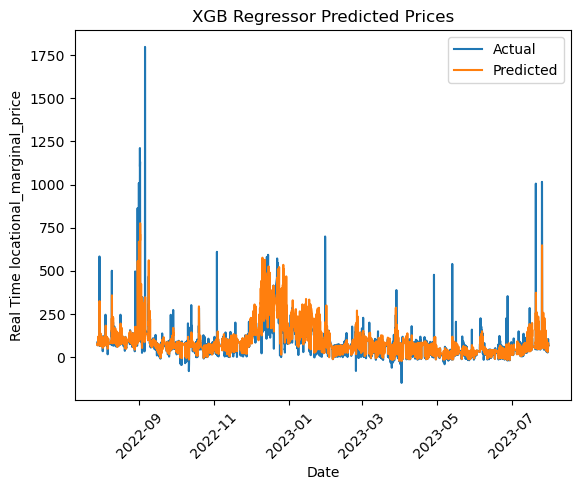

In [33]:
error_df.loc['XGBoost', 'r2'] = metrics.r2_score(y_test, xgb_reg_pred)
error_df.loc['XGBoost', 'rmse'] = metrics.mean_squared_error(y_test, xgb_reg_pred, squared=False)
error_df.loc['XGBoost', 'mae'] = metrics.mean_absolute_error(y_test, xgb_reg_pred)
error_df.loc['XGBoost', 'mape'] = metrics.mean_absolute_percentage_error(y_test, xgb_reg_pred)

print('Results for XGBoost model', '-------------------------', sep='\n')
print("R2 Score:", round(error_df.loc['XGBoost', 'r2'],2))
print("RMSE", round(error_df.loc['XGBoost', 'rmse'],2))
print("MAE", round(error_df.loc['XGBoost', 'mae'],2))
print("MAPE", round(error_df.loc['XGBoost', 'mape'],2))

plot_lmp_pred(y_test, xgb_reg_pred)
plt.title('XGB Regressor Predicted Prices')
plt.show()

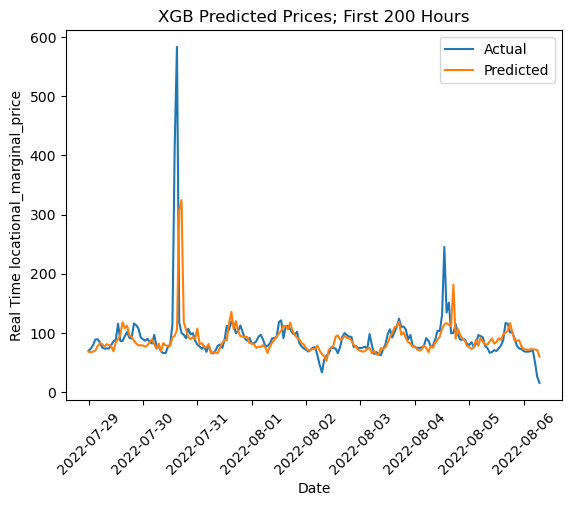

In [34]:
xgb_reg_pred_first200 = xgb_reg.predict(X_test[:200])

plot_lmp_pred(y_test[:200], xgb_reg_pred_first200)
plt.title('XGB Predicted Prices; First 200 Hours')
plt.show()

# Deep Neural Network

In [35]:
# Define a Deep Neural Network Model

# Count number of features to define width of input layer
features_shape = X_train.shape[1]

layers = [
    
    Dense(features_shape),

    BatchNormalization(),
    
    Dense(100, activation='relu'),
    Flatten(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(
    units=1,
    kernel_initializer=GlorotUniform(seed=48),
    activation='linear'
    )
]


model = Sequential(layers)

model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[
        'mean_absolute_error', 
        tf.keras.losses.MeanSquaredError()
    ])

In [36]:
%%time

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

history = model.fit(
    np.array(X_train_arr), 
    np.array(y_train_arr),
    epochs=20,
    batch_size=32,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.1,
            patience=5,
            cooldown=10,
            verbose=0
        ),
    ]
)

Epoch 1/20


2023-11-28 19:48:49.768147: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


537/537 [==============================] - 1s 630us/step - loss: 4128.3149 - mean_absolute_error: 40.6404 - mean_squared_error: 4127.7651 - lr: 0.0010
Epoch 2/20
537/537 [==============================] - 0s 617us/step - loss: 2914.6333 - mean_absolute_error: 28.6446 - mean_squared_error: 2914.2192 - lr: 0.0010
Epoch 3/20
537/537 [==============================] - 0s 623us/step - loss: 2203.8733 - mean_absolute_error: 19.2678 - mean_squared_error: 2203.5076 - lr: 0.0010
Epoch 4/20
537/537 [==============================] - 0s 620us/step - loss: 2000.4856 - mean_absolute_error: 16.5613 - mean_squared_error: 2000.2063 - lr: 0.0010
Epoch 5/20
537/537 [==============================] - 0s 617us/step - loss: 1993.8306 - mean_absolute_error: 16.8323 - mean_squared_error: 1993.5677 - lr: 0.0010
Epoch 6/20
537/537 [==============================] - 0s 621us/step - loss: 1949.6282 - mean_absolute_error: 16.6288 - mean_squared_error: 1949.3188 - lr: 0.0010
Epoch 7/20
537/537 [===================

In [37]:
y_pred = model.predict(X_test_arr)

238/238 [==============================] - 0s 307us/step


Results for DNN model
---------------------
R2 Score: 0.36
RMSE 71.24
MAE 38.67
MAPE 15.8


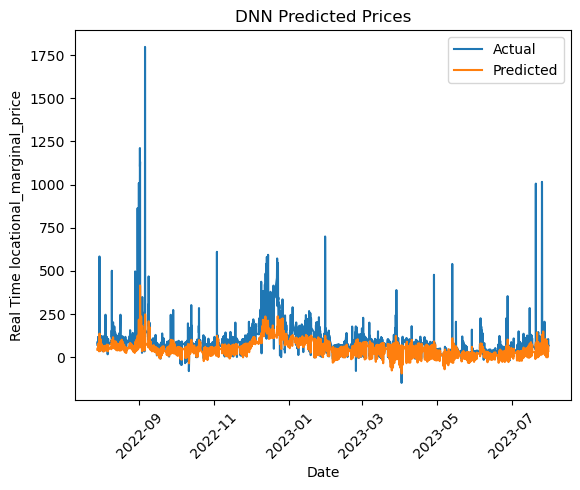

In [38]:
error_df.loc['DNN', 'r2'] = metrics.r2_score(y_test, y_pred)
error_df.loc['DNN', 'rmse'] = metrics.mean_squared_error(y_test, y_pred, squared=False)
error_df.loc['DNN', 'mae'] = metrics.mean_absolute_error(y_test, y_pred)
error_df.loc['DNN', 'mape'] = metrics.mean_absolute_percentage_error(y_test, y_pred)

print('Results for DNN model', '---------------------', sep='\n')
print("R2 Score:", round(error_df.loc['DNN', 'r2'], 2))
print("RMSE", round(error_df.loc['DNN', 'rmse'], 2))
print("MAE", round(error_df.loc['DNN', 'mae'], 2))
print("MAPE", round(error_df.loc['DNN', 'mape'], 2))

plot_lmp_pred(y_test, y_pred.reshape(-1))
plt.title('DNN Predicted Prices')
plt.show()

# Recurrent Neural Networks

In [39]:
# For these RNNs, I will define a lookback window of 24 hours. Therefore, we will not need the lagged variables as we used in the previous models

rnn_vars = [# Target variable and related prices at current hour
             'RT_locational_marginal_price', 'RT_marginal_congestion_component', 'RT_marginal_energy_component', 'RT_marginal_loss_component', 'RT_marginal_greenhouse_gas_component', 
             # Day ahead Prices
             'DA_locational_marginal_price', 'DA_marginal_congestion_component', 'DA_marginal_energy_component', 'DA_marginal_loss_component',
            # Generation
             'Export', 'Generation', 'Import',
             'lagged_2hr_DA_locational_marginal_price',
             # Temperature
             'temperature_2m',
             # Time-Related Variables
             'friday', 'weekend',
             'sin_hour', 'cos_hour',
             'sin_month', 'cos_month']

rnn_features = [# Target variable and related prices at current hour
                'RT_locational_marginal_price', 'RT_marginal_congestion_component', 'RT_marginal_energy_component', 'RT_marginal_loss_component', 'RT_marginal_greenhouse_gas_component', 
                 # Day ahead Prices
                 'DA_locational_marginal_price', 'DA_marginal_congestion_component', 'DA_marginal_energy_component', 'DA_marginal_loss_component',
                # Generation
                 'Export', 'Generation', 'Import',
                 'lagged_2hr_DA_locational_marginal_price',
                 # Temperature
                 'temperature_2m',
                 # Time-Related Variables
                 'friday', 'weekend',
                 'sin_hour', 'cos_hour',
                 'sin_month', 'cos_month']
 
rnn_target = [# Target variable
               'RT_locational_marginal_price']

rnn_df = df[rnn_vars]

num_features = len(rnn_features)
# rnn_df = df[rnn_vars].dropna(axis=0)

In [40]:
def create_rnn_dataset(df, features, target, window_size, prediction_gap_value=2, prediction_gap_units='H', scaler=False):
    """Prepares a time series dataset for an rnn model with a specified window size and prediction steps.

    Args:
        df (pandas.DataFrame): The time series dataset.
        window_size (int): The number of observations in the input window.
        prediction_gap_value (int): Value of prediction gap units between feature timestamp and prediction timestamp.
        prediction_gap_units (str): Units of time between feature timestamp and prediction timestamp, e.g., minutes, hours.
        scaler: Instance of a scaler that normalizes the data.

    Returns:
        Tuple: A tuple containing the input sequences and corresponding output values."""

    # Initialize empty lists for input sequences and output values
    inputs = []
    outputs = []

    # Extract relevant data from the input DataFrame
    input_df = df[features]
    output_df = df[target]
    output_array = np.array(output_df).reshape(-1, 1)
    
    # Scale the data using a MinMaxScaler if the 'scaler' argument is set to True
    if scaler:
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        input_df = pd.DataFrame(scaler_X.fit_transform(input_df), index=input_df.index, columns=input_df.columns)
        
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        output_df = pd.Series(scaler_y.fit_transform(output_array).reshape(-1,), index=output_df.index, name=output_df.name)

    # Iterate through the data to create input-output pairs with the specified window size and prediction gap
    for i in range(len(input_df) - window_size):
        input_group = input_df.iloc[i:i + window_size]
        input_last_timestamp = input_group.index.max()
        output_timestamp = input_last_timestamp + pd.Timedelta(value=prediction_gap_value, unit=prediction_gap_units)
        
        # Check if the output timestamp is present in the output DataFrame. If so, add input-output pair to the data
        if output_timestamp in output_df.index: 
            inputs.append(input_group)
            outputs.append(pd.Series(output_df.loc[output_timestamp], index=[output_timestamp]))

    # Organize input and output data into DataFrames with appropriate indexing
    inputs = pd.DataFrame(pd.concat(inputs))
    index_vals = list(range(int(len(inputs)/window_size)))
    inputs_index = [num for num in index_vals for _ in range(window_size)]

    inputs['index_grouping'] = inputs_index
    inputs.set_index('index_grouping', append=True, inplace=True)
    inputs.index.set_names(['datetime', 'index_grouping'], inplace=True)
    inputs = inputs.reorder_levels(['index_grouping','datetime'])

    outputs = pd.DataFrame(pd.concat(outputs))
    outputs['index_grouping'] = index_vals
    outputs.set_index('index_grouping', append=True, inplace=True)
    outputs.index.set_names(['datetime', 'index_grouping'], inplace=True)
    outputs = outputs.reorder_levels(['index_grouping','datetime'])
    
    # Return the input sequences, output values, and scaler instances (if applicable)
    return inputs, outputs, scaler_X, scaler_y


## 2 Hour Prediction Gap

In [41]:
rnn_X, rnn_y, scaler_X, scaler_y = create_rnn_dataset(df=rnn_df, 
                                                            features=rnn_features, 
                                                            target='RT_locational_marginal_price', 
                                                            window_size=24,
                                                            prediction_gap_value=2, 
                                                            prediction_gap_units='H',
                                                            scaler=True)

In [42]:
# Defining indices to use when splitting into training, validation and test sets
train_idx = rnn_df[rnn_df.index < '01-01-2022'].shape[0]
test_idx = rnn_df[rnn_df.index <= '2022-07-29'].shape[0]

# Splitting into training, validation and test sets
rnn_train_X = rnn_X.loc[0:train_idx]
rnn_train_y = rnn_y.loc[0:train_idx]

rnn_val_X = rnn_X.loc[train_idx+1:test_idx-1]
rnn_val_y = rnn_y.loc[train_idx+1:test_idx-1]

rnn_test_X = rnn_X.loc[test_idx:]
rnn_test_y = rnn_y.loc[test_idx:]

In [43]:
rnn_train_X.shape, rnn_train_y.shape

((308472, 20), (12853, 1))

In [44]:
# Condition window refers to the "lookback" period of features that the model considers when predicting a given target value
# For example, we use a condition window of 24 hours prior
# Prediction window is equal to 1 because we are only predicting a single target value at a time

condition_window = 24
prediction_window = 1
features_length = len(rnn_features)


# Functions used to ensure data is properly formatted for RNN
# These preprocessing functions taken from my Advanced Machine Learning class (provided by Professor Vaschchilenko)
def expected_X_shape(actual_X_shape):
    return (int(actual_X_shape[0]/condition_window), condition_window, features_length)

def expected_y_shape(actual_y_shape):
    return (int(actual_y_shape[0]/prediction_window), prediction_window)


pd.DataFrame({
    'actual shape': [
        rnn_train_X.shape, 
        rnn_train_y.shape,
    ],
    'expected shape': [
        expected_X_shape(rnn_train_X.shape), 
        expected_y_shape(rnn_train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(308472, 20)","(12853, 24, 20)"
train_y,"(12853, 1)","(12853, 1)"


In [45]:
# Function that reshapes data to be used by RNN
# This preprocessing function taken from my Advanced Machine Learning class (provided by Professor Vaschchilenko). Modified by me for this data type.
def frame_to_ndarray(frame_X, frame_y):
    X_nd = frame_X.reshape(-1, condition_window, features_length).astype('float32')
    y_nd = frame_y.values.reshape(-1, prediction_window).astype('float32')
    return X_nd, y_nd


train_X_nd, train_y_nd = frame_to_ndarray(np.array(rnn_train_X), rnn_train_y)
validate_X_nd, validate_y_nd = frame_to_ndarray(np.array(rnn_val_X), rnn_val_y)
test_X_nd, test_y_nd = frame_to_ndarray(np.array(rnn_test_X), rnn_test_y)

In [46]:
# Verufy that data has been reshaped correctly
pd.DataFrame({
    'actual shape': [
        train_X_nd.shape, 
        train_y_nd.shape,
    ],
    'expected shape': [
        expected_X_shape(rnn_train_X.shape), 
        expected_y_shape(rnn_train_y.shape), 
    ],
}, index=['train_X', 'train_y'])

,actual shape,expected shape
train_X,"(12853, 24, 20)","(12853, 24, 20)"
train_y,"(12853, 1)","(12853, 1)"


## Long Short-Term Memory Model

In [93]:
# Define Vanilla LSTM model
layers = [LSTM(100, input_shape=(24, num_features)),
        Flatten(),
        Dense(200, activation='relu'),
        Dropout(0.1),
        Dense(1)]

model = Sequential(layers)

model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[
        'mean_absolute_error', 
        tf.keras.losses.MeanSquaredError()
    ])

2023-11-28 20:15:26.846466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-28 20:15:26.846969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-28 20:15:26.847555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [94]:
%%time

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=50,
    batch_size=32,)

Epoch 1/50


2023-11-28 20:15:26.945988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [12853,24,20]
	 [[{{node Placeholder/_10}}]]
2023-11-28 20:15:26.946189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [12853,1]
	 [[{{node Placeholder/_11}}]]
2023-11-28 20:15:27.063824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2

397/402 [============================>.] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0184 - mean_squared_error: 0.0012

2023-11-28 20:15:31.230604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [4329,24,20]
	 [[{{node Placeholder/_10}}]]
2023-11-28 20:15:31.230770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [4329,1]
	 [[{{node Placeholder/_11}}]]
2023-11-28 20:15:31.346113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

402/402 [==============================] - 5s 10ms/step - loss: 0.0012 - mean_absolute_error: 0.0184 - mean_squared_error: 0.0012 - val_loss: 4.7834e-04 - val_mean_absolute_error: 0.0141 - val_mean_squared_error: 4.7835e-04
Epoch 2/50
402/402 [==============================] - 4s 9ms/step - loss: 7.1749e-04 - mean_absolute_error: 0.0124 - mean_squared_error: 7.1725e-04 - val_loss: 4.6350e-04 - val_mean_absolute_error: 0.0130 - val_mean_squared_error: 4.6417e-04
Epoch 3/50
402/402 [==============================] - 4s 9ms/step - loss: 6.7269e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 6.7219e-04 - val_loss: 3.9325e-04 - val_mean_absolute_error: 0.0114 - val_mean_squared_error: 3.9229e-04
Epoch 4/50
402/402 [==============================] - 4s 9ms/step - loss: 6.4152e-04 - mean_absolute_error: 0.0110 - mean_squared_error: 6.4107e-04 - val_loss: 4.0682e-04 - val_mean_absolute_error: 0.0117 - val_mean_squared_error: 4.0624e-04
Epoch 5/50
402/402 [==============================

In [95]:
y_hat = scaler_y.inverse_transform(model.predict(test_X_nd))

  1/231 [..............................] - ETA: 43s

2023-11-28 20:18:27.465373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [7385,24,20]
	 [[{{node Placeholder/_10}}]]
2023-11-28 20:18:27.465534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [7385,24,20]
	 [[{{node Placeholder/_10}}]]
2023-11-28 20:18:27.560614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split

231/231 [==============================] - 1s 3ms/step


Results for LSTM model
----------------------
R2 Score: 0.29
RMSE 75.59
MAE 37.0
MAPE 11.24


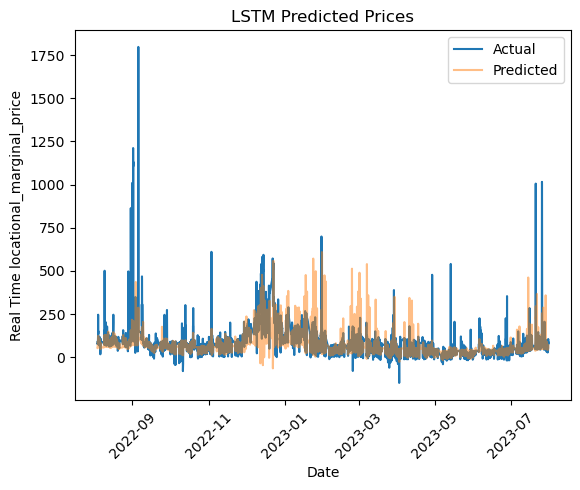

In [96]:
# Add dates to y_true in order to plot results
date_index = rnn_test_y.index.get_level_values(level=1)
rnn_y_true = pd.Series(scaler_y.inverse_transform(test_y_nd).reshape(-1,), index=date_index)


error_df.loc['LSTM', 'r2'] = metrics.r2_score(scaler_y.inverse_transform(test_y_nd), y_hat)
error_df.loc['LSTM', 'rmse'] = metrics.mean_squared_error(scaler_y.inverse_transform(test_y_nd), y_hat, squared=False)
error_df.loc['LSTM', 'mae'] = metrics.mean_absolute_error(scaler_y.inverse_transform(test_y_nd), y_hat)
error_df.loc['LSTM', 'mape'] = metrics.mean_absolute_percentage_error(scaler_y.inverse_transform(test_y_nd), y_hat)

print('Results for LSTM model', '----------------------', sep='\n')
print("R2 Score:", round(error_df.loc['LSTM', 'r2'], 2))
print("RMSE", round(error_df.loc['LSTM', 'rmse'], 2))
print("MAE", round(error_df.loc['LSTM', 'mae'], 2))
print("MAPE", round(error_df.loc['LSTM', 'mape'], 2))

plot_lmp_pred(rnn_y_true, y_hat.reshape(-1,), alpha=0.5)
plt.title('LSTM Predicted Prices')
plt.show()

In [51]:
# # Plot error over the course of training
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.legend(['Test', 'Validation'])
# plt.xlabel('No. Epochs')
# plt.ylabel('Mean Squared Error')
# plt.title("LSTM Model Mean Squared Error")

## Gated Recurrent Unit Model

In [52]:
# Create GRU Model
layers = [
    
        GRU(
            input_shape=(24, num_features),
            units=100,
            return_sequences=True,
            recurrent_activation='sigmoid',
            reset_after=True,
            kernel_initializer=GlorotUniform(seed=42),
            recurrent_initializer=GlorotUniform(seed=43),
            kernel_regularizer=tf.keras.regularizers.L2(0.01), 
            recurrent_regularizer=tf.keras.regularizers.L2(l2=0.01), 
        ),
        BatchNormalization(),
        Dense(100, activation='relu'),
        Flatten(),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(
            units=1,
            kernel_initializer=GlorotUniform(seed=48),
            activation='linear'
        )
]



model = Sequential(layers)

model.compile(
    optimizer=Adam(learning_rate=10e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[
        'mean_absolute_error', 
        tf.keras.losses.MeanSquaredError()
    ])

2023-11-28 19:51:57.915722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-28 19:51:57.916299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-28 19:51:57.916915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 100)           36600     
                                                                 
 batch_normalization_2 (Batc  (None, 24, 100)          400       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 24, 100)           10100     
                                                                 
 flatten_2 (Flatten)         (None, 2400)              0         
                                                                 
 dense_7 (Dense)             (None, 16)                38416     
                                                                 
 batch_normalization_3 (Batc  (None, 16)               64        
 hNormalization)                                      

In [54]:
%%time

from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

history = model.fit(
    train_X_nd,
    train_y_nd,
    validation_data=(validate_X_nd, validate_y_nd),
    epochs=120,
    batch_size=32,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.1,
            patience=5,
            cooldown=10,
            verbose=0
        ),

    ]
)

Epoch 1/120


2023-11-28 19:51:58.089543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-28 19:51:58.090256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-28 19:51:58.091125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

402/402 [==============================] - ETA: 0s - loss: 0.1250 - mean_absolute_error: 0.0644 - mean_squared_error: 0.0210

2023-11-28 19:52:02.872906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-28 19:52:02.873595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-28 19:52:02.874307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

402/402 [==============================] - 5s 11ms/step - loss: 0.1250 - mean_absolute_error: 0.0644 - mean_squared_error: 0.0210 - val_loss: 0.2293 - val_mean_absolute_error: 0.4757 - val_mean_squared_error: 0.2271 - lr: 0.0100
Epoch 2/120
402/402 [==============================] - 4s 11ms/step - loss: 0.0023 - mean_absolute_error: 0.0232 - mean_squared_error: 0.0013 - val_loss: 0.0106 - val_mean_absolute_error: 0.1000 - val_mean_squared_error: 0.0102 - lr: 0.0100
Epoch 3/120
402/402 [==============================] - 4s 11ms/step - loss: 0.0013 - mean_absolute_error: 0.0159 - mean_squared_error: 9.3517e-04 - val_loss: 0.0037 - val_mean_absolute_error: 0.0557 - val_mean_squared_error: 0.0035 - lr: 0.0100
Epoch 4/120
402/402 [==============================] - 4s 11ms/step - loss: 0.0012 - mean_absolute_error: 0.0144 - mean_squared_error: 8.8002e-04 - val_loss: 0.0031 - val_mean_absolute_error: 0.0419 - val_mean_squared_error: 0.0024 - lr: 0.0100
Epoch 5/120
402/402 [===================

In [55]:
y_hat = scaler_y.inverse_transform(model.predict(test_X_nd))

 18/231 [=>............................] - ETA: 0s 

2023-11-28 20:00:32.808600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-28 20:00:32.809227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-28 20:00:32.809886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

231/231 [==============================] - 1s 3ms/step


Results for GRU model
---------------------
R2 Score: 0.62
RMSE 55.58
MAE 24.21
MAPE 18.85


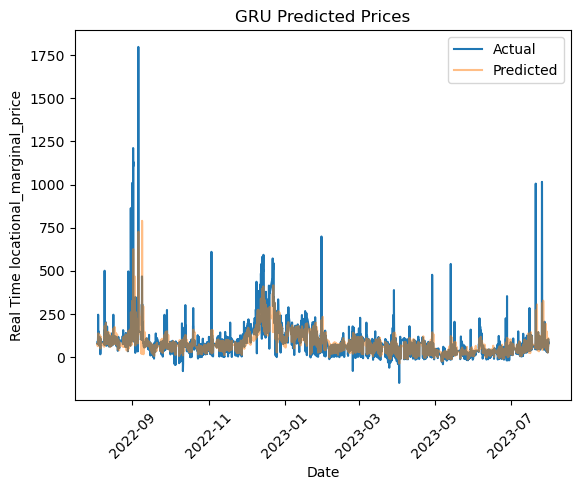

In [56]:
error_df.loc['GRU', 'r2'] = metrics.r2_score(scaler_y.inverse_transform(test_y_nd), y_hat)
error_df.loc['GRU', 'rmse'] = metrics.mean_squared_error(scaler_y.inverse_transform(test_y_nd), y_hat, squared=False)
error_df.loc['GRU', 'mae'] = metrics.mean_absolute_error(scaler_y.inverse_transform(test_y_nd), y_hat)
error_df.loc['GRU', 'mape'] = metrics.mean_absolute_percentage_error(scaler_y.inverse_transform(test_y_nd), y_hat)

print('Results for GRU model', '---------------------', sep='\n')
print("R2 Score:", round(error_df.loc['GRU', 'r2'], 2))
print("RMSE", round(error_df.loc['GRU', 'rmse'], 2))
print("MAE", round(error_df.loc['GRU', 'mae'], 2))
print("MAPE", round(error_df.loc['GRU', 'mape'], 2))

plot_lmp_pred(rnn_y_true, y_hat.reshape(-1,), alpha=0.5)
plt.title('GRU Predicted Prices')
plt.show()

In [57]:
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.legend(['Test', 'Validation'])
# plt.xlabel('No. Epochs')
# plt.ylabel('Mean Squared Error')
# plt.title("GRU Model Mean Squared Error")

# Final Model Results

Of all models, the Random Forest achieves the best performance for all metrics except Mean Absolute Percent Error. Surprisingly, the 'current hour' persistence model has the lowest Mean Absolute Percent Error. Comparing observations where the Random Forest percentage error is much higher than the Persistence model percentage error, we can see that this phenomenon is likely driven by instances where the target value is close to 0. In other words, slight increases in over- or underprediction will lead to large increases in MAPE.

In [97]:
print(error_df.astype(float).round(2))

                     r2   rmse    mae   mape
Model                                       
persist_prev_day   0.41  68.19  27.75  24.78
persist_curr_hour  0.47  64.47  23.84   6.60
Random Forest      0.69  49.36  20.49  25.09
XGBoost            0.58  57.75  25.17  20.81
DNN                0.36  71.24  38.67  15.80
LSTM               0.29  75.59  37.00  11.24
GRU                0.62  55.58  24.21  18.85


In [118]:
error_df['r2'].astype(float).idxmax()

'Random Forest'

In [126]:
print(f"Best R-Squared: {error_df['r2'].astype(float).idxmax()} ({error_df['r2'].max().round(2)})")
print(f"Best RMSE: {error_df['rmse'].astype(float).idxmin()} ({error_df['rmse'].min().round(2)})")
print(f"Best MAE: {error_df['mae'].astype(float).idxmin()} ({error_df['mae'].min().round(2)})")
print(f"Best MAPE: {error_df['mape'].astype(float).idxmin()} ({error_df['mape'].min().round(2)})")

Best R-Squared: Random Forest (0.69)
Best RMSE: Random Forest (49.36)
Best MAE: Random Forest (20.49)
Best MAPE: persist_curr_hour (6.6)


In [193]:
# Create a DataFrame that shows percentage error by hour for the Persistence and Random Forest models
persist_perc_error = np.abs(y_test - persist_y_pred_curr_hour) / y_test
rf_perc_error = np.abs(y_test - rf_reg_pred) / y_test

mape_df = pd.concat([y_test, pd.Series(persist_y_pred_curr_hour, index=y_test.index), pd.Series(rf_reg_pred, index=y_test.index), persist_perc_error, rf_perc_error], axis=1)
mape_df.columns = ['y_test', 'persist_y_pred_curr_hour', 'rf_reg_pred', 'persist_curr_hour_mape', 'rf_mape']

In [194]:
mape_df['diff_mape'] = mape_df['persist_curr_hour_mape'] - mape_df['rf_mape']
mape_df.sort_values('diff_mape', ascending=True).head(10)

,y_test,persist_y_pred_curr_hour,rf_reg_pred,persist_curr_hour_mape,rf_mape,diff_mape
2023-05-29 11:00:00-07:00,0.003598,0.101559,4.931914,27.230484,1369.928019,-1342.697535
2023-05-29 13:00:00-07:00,0.006850,0.003598,7.468010,0.474818,1089.220389,-1088.745572
2023-05-25 11:00:00-07:00,0.003279,21.127671,23.774266,6442.000000,7249.093817,-807.093817
2023-06-14 09:00:00-07:00,-0.001125,-4.755938,-4.232599,-4226.500741,-3761.310476,-465.190264
2023-04-14 14:00:00-07:00,0.006066,6.656382,9.313653,1096.356505,1534.428455,-438.071950
2023-04-08 14:00:00-07:00,-0.012387,-12.347745,-7.029271,-995.857777,-566.486896,-429.370881
2023-03-15 12:00:00-07:00,0.027082,12.285132,20.901576,452.632777,770.798003,-318.165226
2022-11-19 11:00:00-08:00,0.103662,38.779064,64.129848,373.092617,617.645732,-244.553115
2022-09-17 11:00:00-07:00,0.143957,5.277852,30.080194,35.662568,207.951905,-172.289337
2023-06-21 05:00:00-07:00,-0.446561,122.264777,50.761521,-274.791986,-114.672131,-160.119855


In [91]:
print(error_df.astype(float).round(2).to_markdown())

| Model             |   r2 |   rmse |   mae |   mape |
|:------------------|-----:|-------:|------:|-------:|
| persist_prev_day  | 0.41 |  68.19 | 27.75 |  24.78 |
| persist_curr_hour | 0.47 |  64.47 | 23.84 |   6.6  |
| Random Forest     | 0.69 |  49.36 | 20.49 |  25.09 |
| XGBoost           | 0.58 |  57.75 | 25.17 |  20.81 |
| DNN               | 0.36 |  71.24 | 38.67 |  15.8  |
| LSTM              | 0.09 |  85.3  | 39.49 |  21.2  |
| GRU               | 0.62 |  55.58 | 24.21 |  18.85 |
